# Cardiovascular Risk Prediction in Cleveland Population: A Predictive Analysis of Heart Disease Occurrence

## Introduction

Coronary diseases pose significant challenges to everyday wellbeing, requiring precise predictive models where understanding diagnostic factors is crucial. Utilizing a dataset of clinical test results and cardiovascular diagnosis, this analysis focuses on the relationship between age, maximum heart rate, and diagnosis levels in Cleveland. The unique healthcare landscape and lifestyle factors make this exploration essential for tailored interventions and improved cardiovascular risk assessment in the Cleveland population. Thus, this project will explore the following: Can maximum heart rate and age be used to predict heart disease in Clevelanders?

This analysis' heart disease dataset is from a database created to test a discriminant function model (Detrano, 1989), developed using clinical and noninvasive test results from patients undergoing angiography. Collected from groups in Hungary, Switzerland, Long Beach, and Cleveland, the database encompasses variables including demographics, chest pain, resting blood pressure, cholesterol levels, maximum heart rate and other relevant features for diagnosis. The proposed model focuses on the dataset of 303 Cleveland Clinic patients. 

## Methods and Results

In [16]:
# load all necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘cowplot’ was built under R version 4.3.2”

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




### Preliminary analysis

In [2]:
# downloading and reading data, naming columns
url <- "https://raw.githubusercontent.com/ssun05/dsci_100_002_group5_project/main/processed.cleveland.data"
heart_data <- read_csv(url, col_names = c("age", "sex", "chest_pain", "trestbps", "chol", "fasting_bld_sgar",
                                                      "restecg", "max_heart_rate", "exerc_angina", "oldpeak", "slope", "ca", "thal", "diagnosis"))
print("Table 1: Full Heart Dataset")
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, chest_pain, trestbps, chol, fasting_bld_sgar, restecg, m...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Full Heart Dataset"


age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [3]:
# filter for males and reclass diagnosis as factor, make labels understandable
heart_data_renamed <- heart_data |> 
                    mutate(diagnosis = as_factor(diagnosis)) |>
                    mutate(diagnosis = fct_recode(diagnosis, "no" = "0", "yes" = "1", "yes" = "2", "yes" = "3", "yes" = "4"))

print("Table 2: Heart Dataset - Males only")
heart_data_renamed

[1] "Table 2: Heart Dataset - Males only"


age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,no
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,no


In [4]:
set.seed(1234)

# split data for training and testing
heart_split <- initial_split(heart_data_renamed, prop = 0.75, strata = diagnosis)

heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [5]:
# table of diagnosis counts
label_counts <- heart_train |>
                group_by(diagnosis) |>
                summarize(count = n())
print("Table 3: Diagnosis Class Counts")
label_counts

missing_data <- heart_train |> 
                filter(age == NA | max_heart_rate == NA | diagnosis == NA |
                       age == "?" | max_heart_rate == "?" | diagnosis == "?") |>
                    summarize(missing_data = n())

print("Table 4: Missing Data Count")
missing_data

[1] "Table 3: Diagnosis Class Counts"


diagnosis,count
<fct>,<int>
no,123
yes,104


[1] "Table 4: Missing Data Count"


missing_data
<int>
0


[1] "Table 5: Mean Heart Rates per Heart Disease Diagnoses"


diagnosis,mean_heart
<fct>,<dbl>
no,157.4797
yes,139.0673


[1] "Figure 1: Mean Heart Rates per Heart Disease Diagnoses"


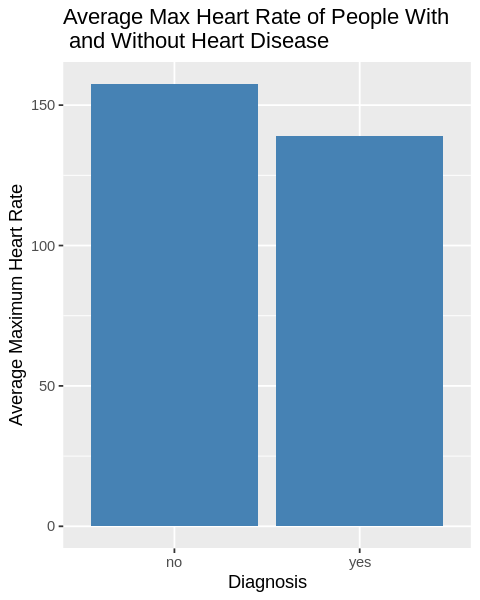

In [6]:
# predictor mean: heart rate
mean_max_hrt_rate <- heart_train |>
                        group_by(diagnosis) |>
                        summarize(mean_heart = mean(max_heart_rate))

print("Table 5: Mean Heart Rates per Heart Disease Diagnoses")
mean_max_hrt_rate

options(repr.plot.width = 4, repr.plot.height = 5)
avg_hrt_plot <- mean_max_hrt_rate |> 
                ggplot(aes(x = diagnosis, y = mean_heart)) +
                geom_bar(stat = "identity", fill = "steelblue") +
                labs(x = "Diagnosis", y = "Average Maximum Heart Rate") +
                ggtitle("Average Max Heart Rate of People With \n and Without Heart Disease")

print("Figure 1: Mean Heart Rates per Heart Disease Diagnoses")
avg_hrt_plot

[1] "Table 6: Mean Ages per Heart Disease Diagnoses"


diagnosis,mean_age
<fct>,<dbl>
no,52.48780
yes,56.94231


[1] "Figure 2: Mean Ages per Heart Disease Diagnoses"


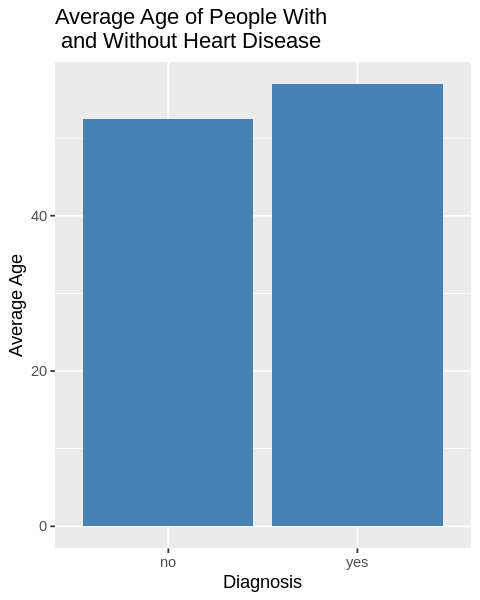

In [7]:
# predictor mean: age
mean_age <- heart_train |>
                group_by(diagnosis) |>
                summarize(mean_age = mean(age))

print("Table 6: Mean Ages per Heart Disease Diagnoses")
mean_age

options(repr.plot.width = 4, repr.plot.height = 5)
avg_hrt_plot <- mean_age |> 
                ggplot(aes(x = diagnosis, y = mean_age)) +
                geom_bar(stat = "identity", fill = "steelblue") +
                labs(x = "Diagnosis", y = "Average Age") +
                ggtitle("Average Age of People With \n and Without Heart Disease")

print("Figure 2: Mean Ages per Heart Disease Diagnoses")
avg_hrt_plot

[1] "Figure 3: Example Visual Inspection of Predictors"
[1] "Figure 4: Example Visual Inspection of Predictors"


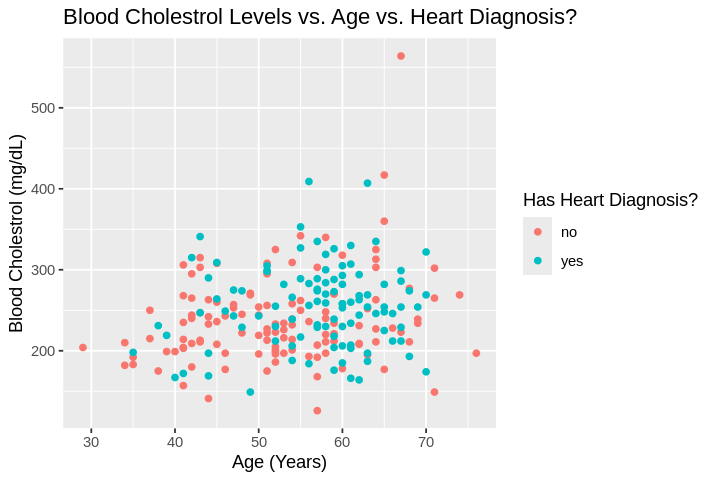

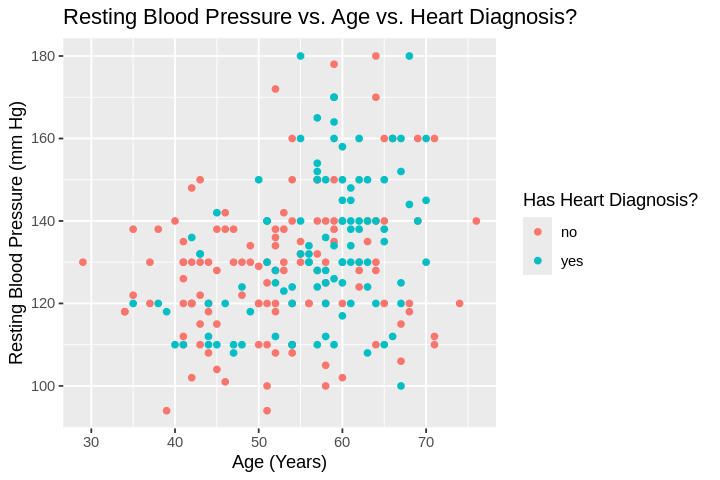

In [8]:
options(repr.plot.width = 6, repr.plot.height = 4)

# example scatterplot compared to choose predictor
variable_test_ex <- heart_train|> 
                ggplot(aes(x = age, y = chol, color = diagnosis)) +
                geom_point() +
                labs(x = "Age (Years)",
                     y = "Blood Cholestrol (mg/dL)",
                     color = "Has Heart Diagnosis?",
                     title = "Blood Cholestrol Levels vs. Age vs. Heart Diagnosis?")

print("Figure 3: Example Visual Inspection of Predictors")
variable_test_ex

variable_test_ex_1 <- heart_train|> 
                ggplot(aes(x = age, y = trestbps, color = diagnosis)) +
                geom_point() +
                labs(x = "Age (Years)",
                     y = "Resting Blood Pressure (mm Hg)",
                     color = "Has Heart Diagnosis?",
                     title = "Resting Blood Pressure vs. Age vs. Heart Diagnosis?")

print("Figure 4: Example Visual Inspection of Predictors")
variable_test_ex_1

[1] "Figure 5: Scatterplot of Max Heart Rate and Age per Heart Disease Diagnosis"


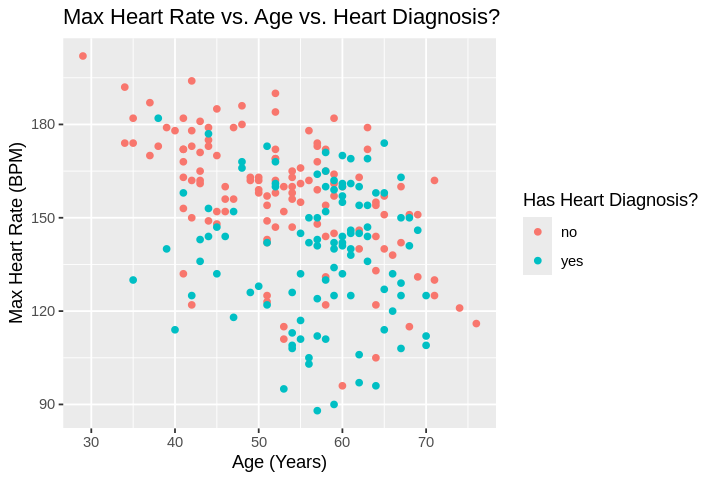

In [9]:
options(repr.plot.width = 6, repr.plot.height = 4)

#scatterplot of final predictors 
heart_plot <- heart_train|> 
                ggplot(aes(x = age, y = max_heart_rate, color = diagnosis)) +
                geom_point() +
                labs(x = "Age (Years)",
                     y = "Max Heart Rate (BPM)",
                     color = "Has Heart Diagnosis?",
                     title = "Max Heart Rate vs. Age vs. Heart Diagnosis?")

print("Figure 5: Scatterplot of Max Heart Rate and Age per Heart Disease Diagnosis")
heart_plot

[1] "Figure 6: Distribution of Age per Heart Disease Diagnosis"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


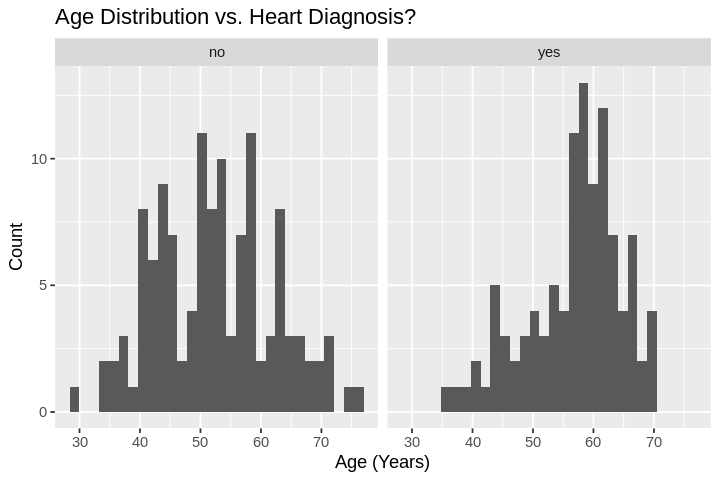

In [10]:
options(repr.plot.width = 6, repr.plot.height = 4)

# distribution of ages
age_distribution <- heart_train|> 
                ggplot(aes(x = age)) +
                geom_histogram() +
                labs(x = "Age (Years)",
                     y = "Count",
                     title = "Age Distribution vs. Heart Diagnosis?") +
                facet_grid(cols = vars(diagnosis))

print("Figure 6: Distribution of Age per Heart Disease Diagnosis")
age_distribution

[1] "Figure 7: Distribution of Max Heart Rate per Heart Disease Diagnosis"


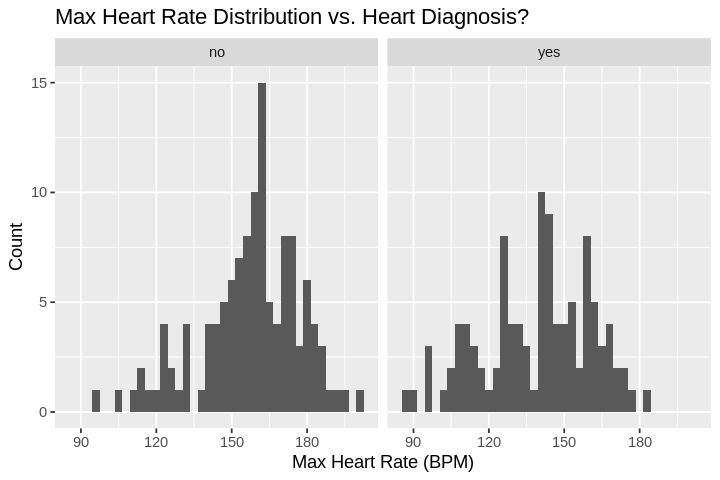

In [11]:
# distribution of max heart rate
max_distribution <- heart_train|> 
                ggplot(aes(x = max_heart_rate)) +
                geom_histogram(binwidth = 3) +
                labs(x = "Max Heart Rate (BPM)",
                     y = "Count",
                     title = "Max Heart Rate Distribution vs. Heart Diagnosis?") +
                facet_grid(cols = vars(diagnosis))

print("Figure 7: Distribution of Max Heart Rate per Heart Disease Diagnosis")
max_distribution

### Methods

We answered the research question using a knn classification model with "age" and "max_heart_rate" variables as predictors, and the presence of a diagnosis as the class label. After comparing the scatterplots of different predictive variables (figure 3, 4 and 5) we found that age and max heart rate yields the most distinct clustering differences between those with a diagnosis and without. This means that using the variables of age and max heart rate allows for the most predictive power in this application. 

"Age" represents the age of a patient at the time of data collection. "max_heart_rate" is also known as *thalach*, and represents a patient's max heart rate achieved. 

We chose to focus on classifying data (k-NN classification) over predicting exact values (k-NN regression) because the diagnosis values ranging from 0 to 4 represent categories of heart disease severity rather than continuous quantitative measurements. Each value signifies a different level or category of heart disease, making it more appropriate to classify as either "no" (0) for absence or "yes" (1 - 4) for presence of heart disease. This approach helps simplify and clarify the distinction between individuals with and without heart disease based on these categorical labels.

We used 5-fold cross-validation to optimize the K-value (number of neighbors) for our model. By testing K values from 1 to 50, we assessed model accuracy across different neighbor counts. This method helps us choose the best K-value that balances prediction accuracy with computational efficiency for classifying heart disease presence.

Finally to build our classifier, we've set up a workflow that includes scaling and centering all predictors (age and maximum heart rate). Using this prepared data, we predict whether someone has heart disease based on the most common class among its nearest neighbors (determined by K-value).

To see how well our classifier performs, we predicted the classes of the testing data with our new classifier. From this we obtained both the accuracies and recall of the classifier on our test data. We visualized our results with a confusion matrix summarizing the observations and our classifier's predictions. We also used two scatterplots with the predictors on the axes with observations coloured by predicted diagnosis on one and actual diagnosis on the other. These charts will be plotted side by side for visual comparison. 

### Analysis

[1] "Figure 8: Graphed accuracies of k-nearest neighbours"


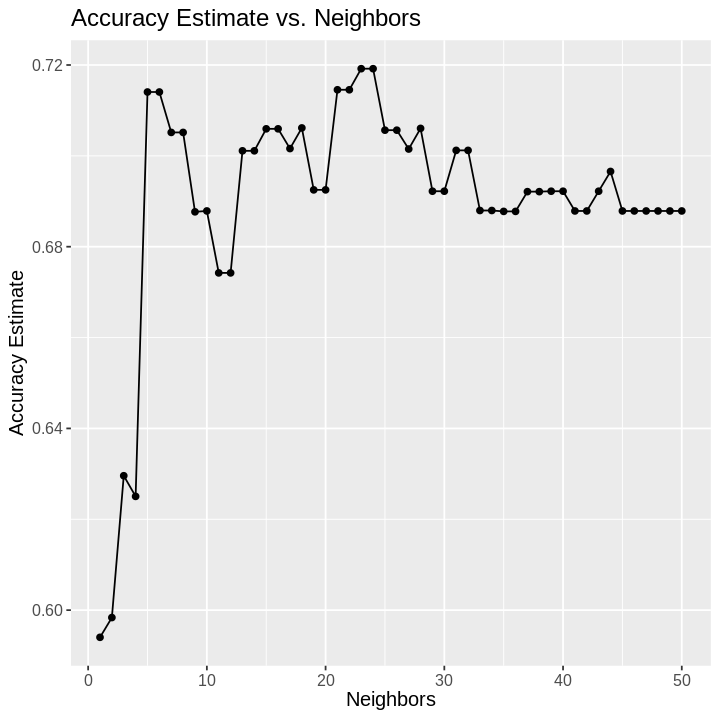

In [12]:
set.seed(9999)

# optimize for a k-value with spec, make recipe
options(repr.plot.height = 6, repr.plot.width = 6)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

training_recipe <- recipe(diagnosis ~ age + max_heart_rate, data = heart_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

training_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

training_fold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

knn_fit <- workflow() |>
  add_recipe(training_recipe) |>
  add_model(training_spec) |>
  tune_grid(resamples = training_fold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_fit |>
  filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate vs. Neighbors") +
  theme(text = element_text(size = 12))

print("Figure 8: Graphed accuracies of k-nearest neighbours")
cross_val_plot

best_k <- accuracies |> select(neighbors, mean) |>
            arrange(-mean) |>
            slice(1) |>
            pull(neighbors)

In [13]:
# redo spec with best k, create fit with recipe
heart_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_spec

heart_fit <- workflow() |>
  add_recipe(training_recipe) |>
  add_model(heart_spec) |>
  fit(data = heart_train)

heart_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = best_k
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(23,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2951542
Best kernel: rectangular
Best k: 23

In [14]:
set.seed(9999)

# run model on test data and evaluate the accuracy, produce confusion matrix
heart_predictions <- predict(heart_fit, heart_test) |> 
                    bind_cols(heart_test)

print("Table 7: Test Heart Data Prediction Diagnoses")
heart_predictions

heart_metrics <- heart_predictions |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate)

print("Table 8: Accuracy of Model on Test Heart Data")
heart_metrics

heart_conf_mat <- heart_predictions |>
             conf_mat(truth = diagnosis, estimate = .pred_class)

print("Figure 9: Test Heart Data Confusion Matrix")
heart_conf_mat

[1] "Table 7: Test Heart Data Prediction Diagnoses"


.pred_class,age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
yes,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,no
no,57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,no
no,53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
yes,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,yes
yes,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,yes
no,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,yes


[1] "Table 8: Accuracy of Model on Test Heart Data"


.estimate
<dbl>
0.7105263


[1] "Figure 9: Test Heart Data Confusion Matrix"


          Truth
Prediction no yes
       no  30  11
       yes 11  24

In [15]:
# recall of model on test data
heart_predictions |> pull(diagnosis) |> levels()

test_recall <- heart_predictions |> recall(truth = diagnosis, estimate = .pred_class, event_level = "second")

print("Table 9: Recall of Model on Test Heart Data")
test_recall

[1] "no"  "yes"

[1] "Table 9: Recall of Model on Test Heart Data"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6857143


[1] "Figure 10: Comparing Predicted Diagnosis and True Diagnosis of Test Data"


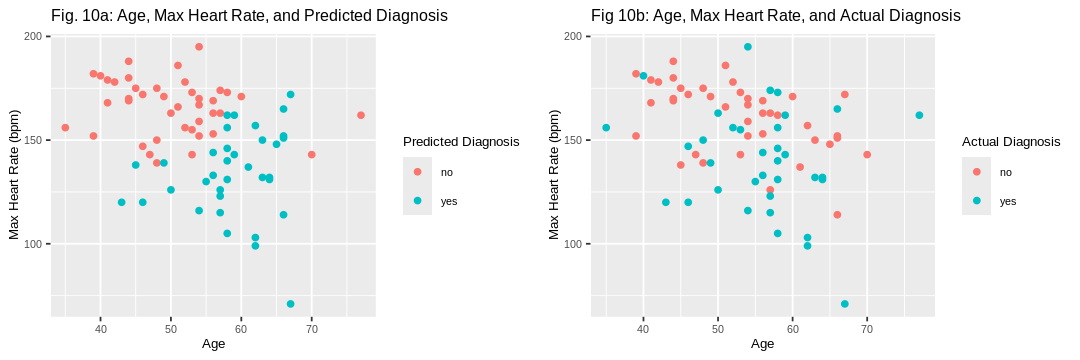

In [25]:
options(repr.plot.width = 9, repr.plot.height = 3)

test_prediction_plot <- heart_predictions |>
                            ggplot(aes(x = age, y = max_heart_rate, color = .pred_class)) +
                            geom_point() +
                            labs(x = "Age", y = "Max Heart Rate (bpm)", color = "Predicted Diagnosis") +
                            ggtitle("Fig. 10a: Age, Max Heart Rate, and Predicted Diagnosis") +
                            theme(text = element_text(size = 8))

actual_diagnosis_plot <- heart_predictions |>
                            ggplot(aes(x = age, y = max_heart_rate, color = diagnosis)) +
                            geom_point() +
                            labs(x = "Age", y = "Max Heart Rate (bpm)", color = "Actual Diagnosis") +
                            ggtitle("Fig 10b: Age, Max Heart Rate, and Actual Diagnosis") +
                            theme(text = element_text(size = 8))


print("Figure 10: Comparing Predicted Diagnosis and True Diagnosis of Test Data")
plot_grid(test_prediction_plot, actual_diagnosis_plot)

## Results
This report used max heart rate (thalach) and age as predictors of heart disease. After performing an 5-fold cross-validation analysis the report found that the best K value to use was 23. The K value of 23 yielded the highest accuracy when performed on the training data. On test data, the model produced an accuracy of 71.1% (Table 8) and recall of 68.6% (Table 9)

## Discussion

Using max heart rate and age to create a model predicting heart disease diagnosis, the model yielded an accuracy of 71.1% and recall of 68.6% when tested on new data. This recall is close to 0.7, considered by CloudFactory (n.d.) to be an acceptable recall for a predictive model; however, this score should be evaluated under a medical context. With heart disease as the second leading cause of death in Canada (Public Health Agency of Canada [PHAC], 2022), it is crucial to minimize the amount of false negatives to allow for early interventions and treatment plans. False negatives may allow the condition to increase in severity, limiting the ways it can be treated and subsequently interfere with daily life and lead to other medical conditions. Thus, we assert a recall of 68.6% is not sufficient, and that this model using age and maximum heart rate as predictors cannot satisfactorily predict heart disease in Clevelanders. 

Medical diagnosis prediction models have stricter recall thresholds to be accepted. Chen et al. (2023) explored various machine learning algorithms predicting breast cancer and were able to achieve a recall of 99.1% using KNN classification and 98.1% using the Random Forest learning algorithm. Their comparisons to previous models in literature displayed recalls from 94.3% to 100%, using methods including logistic regression and XGBoost. Additionally, Hoodhboy et al. (2021) investigated numerous machine learning models to diagnose congenital heart disease and reported existing models with recalls ranging from 80% to 100%. Therefore, comparing other methods and/or models to the recall in our results, our model is not sufficiently precise.

Figure 10a illustrates how overall, our model classified observations with higher max heart rate and relatively lower age as not having heart disease, and observations with lower max heart rate and relatively higher ages as positive for heart disease. This matches what we would expect by looking at Figures 6 and 7, comparing the distribution of max heart rate and age in the presence and absence of heart disease. The distribution of max heart rate is higher and the distribution of age is lower; this is reflected in the predictive model. 

This report is significant in that medical professionals may use this information to identify high-risk individuals and tailor preventive strategies, emphasizing lifestyle modifications. Also, these findings could influence healthcare policy and interventions, directing resources and preventive measures toward populations with higher risk factors. Further research could explore which factor has more influence on heart disease, and evaluate the effectiveness of interventions based on age and maximum heart rates

Future research could delve deeper into understanding the relative influence of age and maximum heart rate on heart disease, potentially uncovering which factor plays a more significant role in disease prediction.  We can use scatter plots and correlation analysis, to fit logistic regression or tree-based models to quantify relationships and feature importance. Visualize findings with plots and summarize insights about predictive power for heart disease risk assessment.Moreover, evaluating the effectiveness of interventions tailored based on age and maximum heart rates could guide the development of targeted preventive measures and treatment strategies.

Overall, these findings underscore the potential impact of leveraging predictive modeling in healthcare to enhance risk assessment and preventive care, ultimately improving health outcomes and resource allocation. Continued research in this area holds promise for advancing personalized medicine and population health management.

## References


Chen, H., Wang, N., Du, X., Mei, K., Zhou, Y., & Cai, G. (2023). Classification prediction of breast cancer based on machine learning. *Computation Intelligence and Neuroscience, 2023*, Article No. 9896565. https://doi.org/10.1155/2023/9896565

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J. J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. *The American Journal of Cardiology, 64*(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9

Hoodhboy, Z., Jiwani, U., Sattar, S., Salam, R., Hasan, B., & Das, J.K. (2021). Diagnostic accuracy of machine learning models to identify congenital heart disease: A meta-analysis. *Frontiers in Artificial Intelligence, 4*. https://doi.org/10.3389/frai.2021.708365

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X

Public Health Agency of Canada. (2022). *Heat Disease in Canada*. Retrieved from Public Health Agency of Canada. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

Recall score, CloudFactory Computer Vision Wiki. (2024). CloudFactory Computer Vision Wiki. https://wiki.cloudfactory.com/docs/mp-wiki/metrics/recall